
>This notebook provides a step-by-step guide to building a machine learning model capable of detecting vehicle types based on scanned images.
>
>The project involves classifying five vehicle categories using a pre-trained MobilenetV2 with Transfer Learning for image feature extraction. The model leverages the extensive ImageNet dataset for initial training.
>
>Additionally, the notebook demonstrates how to add a new classifier by fine-tuning the feature extractor for improved performance.

# Step 1: Load the dependencies

In [1]:
!nvidia-smi

Thu Dec 12 07:50:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import cv2
import time
import json
import shutil
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.transform import resize
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from skimage.io import imread, imshow, imsave
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D

In [3]:
print(tf.__version__)

2.16.1


In [4]:
!pip install roboflow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.9 MB/s eta 0:00:00


# Step 2: Import dataset from roboflow

In [5]:
%cd /kaggle/working/

from roboflow import Roboflow
rf = Roboflow(api_key="58QC3JM4Mlxv0ApYvXZu")
project = rf.workspace("wheefly").project("wheelify2")
version = project.version(4)
dataset = version.download("coco")

/kaggle/working
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to wheelify2-4 in coco:: 100%|██████████| 4591/4591 [00:00<00:00, 6364.33it/s]


# Step 3: Prepare the images, labels, and bounding box from dataset

In [6]:
annotation_train = '/kaggle/working/wheelify2-4/train/_annotations.coco.json'
train_dir = '/kaggle/working/wheelify2-4/train'

images = []
labels = []
bboxes = []

In [7]:
with open(annotation_train) as f:
    data = json.load(f)

In [8]:
for annotations in data['annotations']:
    image_id = annotations['image_id']
    image_info = next(item for item in data['images'] if item['id'] == image_id)
    image_name = image_info['file_name']
    img_path = os.path.join(train_dir, image_name)
    
    if os.path.exists(img_path):
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.astype('float32') / 255

        bbox = annotations['bbox']
        label = annotations['category_id']

        images.append(image)
        labels.append(label)
        bboxes.append(bbox)

In [9]:
print(labels)

[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 3, 1, 1, 5, 1, 2, 5, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 5, 1, 1, 2, 2, 1, 3, 2, 2, 1, 3, 2, 1, 1, 4, 1, 5, 1, 1, 1, 2, 1, 5, 2, 3, 1, 1, 1, 2, 1, 4, 4, 2, 3, 1, 3, 1, 1, 5, 2, 1, 5, 1, 1, 1, 2, 1, 4, 1, 3, 1, 2, 2, 2, 1, 2, 1, 5, 2, 3, 1, 1, 1, 4, 2, 2, 1, 4, 2, 2, 5, 1, 1, 1, 1, 1, 4, 1, 1, 5, 1, 1, 5, 1, 5, 4, 1, 1, 3, 2, 2, 1, 1, 5, 1, 1, 1, 2, 1, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 5, 1, 2, 1, 1, 3, 2, 1, 1, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 1, 1, 1, 2, 5, 1, 2, 5, 5, 3, 1, 2, 1, 4, 1, 2, 2, 4, 2, 3, 1, 5, 1, 2, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 2, 2, 1, 1, 1, 4, 1, 1, 3, 1, 2, 2, 1, 2, 1, 3, 1, 5, 3, 1, 1, 2, 1, 1, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 4, 3, 1, 1, 1, 2, 1, 5, 3, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 2, 1, 5, 1, 3, 3, 1, 1, 1, 1, 1, 1, 2, 

In [10]:
label_map = {1: 'Golongan 1', 2: 'Golongan 2', 3: 'Golongan 3', 4: 'Golongan 4', 5: 'Golongan 5'}
labels = [label_map[label] for label in labels]

In [11]:
print(labels)

['Golongan 2', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 2', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 4', 'Golongan 2', 'Golongan 1', 'Golongan 3', 'Golongan 1', 'Golongan 1', 'Golongan 5', 'Golongan 1', 'Golongan 2', 'Golongan 5', 'Golongan 2', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 2', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 3', 'Golongan 2', 'Golongan 3', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 1', 'Golongan 2', 'Golongan 4', 'Golongan 1', 'Golongan 5', 'Golongan 1', 'Golongan 1', 'Golongan 2', 'Golongan 2', 'Golongan 1', 'Golongan 3', 'Golongan 2', 'Golongan 2', 'Golongan 1', 'Golongan 3', 'Golongan 2', 'Golongan 1', 'Golongan 1', 'Golongan 4', 'Golongan 1', 'Golongan 5', 'Golongan 1', 'Golongan 1', 'Golo

# Step 4: Data processing

In [12]:
images = np.array(images)
bboxes = np.array(bboxes)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [13]:
np.save('labels.npy', label_encoder.classes_)

In [14]:
print(labels)

[1 0 0 ... 0 0 1]


# Step 5: Convert numeric labels to one-hot encoding format

In [15]:
labels = to_categorical(labels, num_classes=5)

In [16]:
print(labels)

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


# Step 6: Split Data 

In [17]:
# Split data into train and test sets
X_train, X_temp, y_train, y_temp, bbox_train, bbox_temp = train_test_split(images, labels, bboxes, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, bbox_val, bbox_test = train_test_split(X_temp, y_temp, bbox_temp, test_size=0.5, random_state=42)

In [18]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

3836
480
480


In [19]:
input_shape = (224, 224, 3)
num_classes = len(label_encoder.classes_)
reg = l2(0.0005)

In [20]:
print(num_classes)

5


# Step 7: Build neural network

In [21]:
def create_model(input_shape, num_classes, reg):

    base_model = MobileNetV2(input_shape = input_shape, include_top = False, weights='imagenet')
    for layers in base_model.layers:
        layers.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    bbox_out = Dense(4, activation = 'linear', name = 'bbox_output')(x)
    class_out = Dense(num_classes, activation = 'softmax', name = 'class_output')(x)

    model = Model(inputs = base_model.input, outputs = [bbox_out, class_out])

    model.compile(optimizer = Adam(learning_rate = 0.0001),
                  loss = {'bbox_output': 'mean_squared_error', 'class_output': 'categorical_crossentropy'},
                  metrics = {'bbox_output': 'mse', 'class_output': 'accuracy'})
    model.summary()

    return model

In [22]:
model = create_model(input_shape, num_classes, reg)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,578,953 (13.65 MB)

 Trainable params: 1,320,969 (5.04 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 8: Training neural network

In [23]:
csv_file = 'training.csv'
    
csv_cb = CSVLogger(csv_file)
checkpoint_cb = ModelCheckpoint('model.keras', save_best_only=True) 

start = time.time()

history = model.fit(
    X_train, {'bbox_output': bbox_train, 
              'class_output': y_train},
    validation_data=(X_val, {'bbox_output': bbox_val,
                             'class_output': y_val}),
    batch_size=32, 
    epochs=150, 
    verbose=1, 
    callbacks=[csv_cb,
              checkpoint_cb]
)

end = time.time()
print("Total train time: ",(end-start)/60," mins")

Epoch 1/150


I0000 00:00:1733989912.521657     107 service.cc:145] XLA service 0x7ebab4010c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733989912.521731     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733989912.521737     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/120 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - bbox_output_mse: 139847.4062 - class_output_accuracy: 0.2556 - loss: 139849.1094

I0000 00:00:1733989920.091999     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - bbox_output_mse: 122131.1172 - class_output_accuracy: 0.3958 - loss: 122133.1250 - val_bbox_output_mse: 78158.8438 - val_class_output_accuracy: 0.5417 - val_loss: 78161.3203
Epoch 2/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - bbox_output_mse: 65018.0312 - class_output_accuracy: 0.3747 - loss: 65024.0547 - val_bbox_output_mse: 29142.7109 - val_class_output_accuracy: 0.5417 - val_loss: 29146.2402
Epoch 3/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - bbox_output_mse: 25740.8516 - class_output_accuracy: 0.3605 - loss: 25750.5508 - val_bbox_output_mse: 17990.0625 - val_class_output_accuracy: 0.5417 - val_loss: 17995.0195
Epoch 4/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - bbox_output_mse: 18063.3809 - class_output_accuracy: 0.4100 - loss: 18073.2090 - val_bbox_output_mse: 16607.3887 - val_class_output_accuracy: 0.5417 - val_loss: 16612.4316
Epoch 5/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - bbox_output_mse: 16772.5938 - class_outp

In [24]:
pd.read_csv(csv_file).tail()

,epoch,bbox_output_mse,class_output_accuracy,loss,val_bbox_output_mse,val_class_output_accuracy,val_loss
145,145,3232.792725,0.806048,3233.303223,4228.387695,0.845833,4228.812500
146,146,3232.325928,0.802920,3232.849121,4228.119141,0.852083,4228.512207
147,147,3231.958008,0.808916,3232.473877,4241.243164,0.868750,4241.619141
148,148,3193.656982,0.815433,3194.162354,4242.875977,0.864583,4243.263672
149,149,3222.156982,0.805005,3222.679199,4262.847168,0.856250,4263.218262


# Step 9: Look at the performance of the model change whilst training

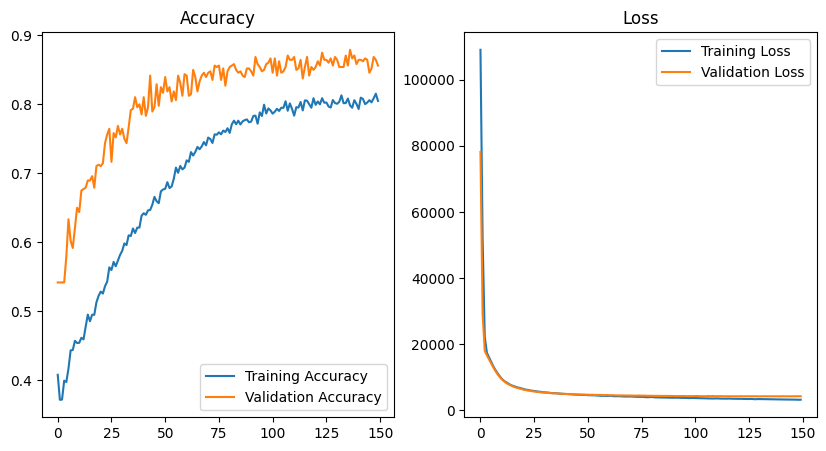

In [25]:
# Plot training results
def plot_training(history):
    acc = history.history['class_output_accuracy']
    val_acc = history.history['val_class_output_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training(history)

# Step 10: Evaluate the model

In [26]:
# Evaluate the model on the test data
test_result = model.evaluate(
    X_test, 
    {'bbox_output': bbox_test, 'class_output': y_test}, 
    batch_size=32
)

# Print the results to check their structure
print(test_result)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - bbox_output_mse: 3640.4617 - class_output_accuracy: 0.8367 - loss: 3640.9207
[3827.0078125, 3826.603271484375, 0.8583333492279053]


In [27]:
predicitons = model.predict(X_test)
predicitons = np.argmax(predicitons[1], axis=1)
predicitons = label_encoder.inverse_transform(predicitons)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


# Step 11: Try out the model from input image

In [28]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalization
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimensions
    return img_array

image_path = "/kaggle/input/isodetect/dataset_iso/gol2_depann.JPG"
preprocessed_image = preprocess_image(image_path)


In [29]:
from tensorflow.keras.models import load_model

model = models.load_model('model.keras')

In [30]:
predictions = model.predict(preprocessed_image)

# Example for classification:
labels = np.load('/kaggle/working/labels.npy')
predicted_class_index = np.argmax(predictions[1], axis=1)  # Classification model output
predicted_label = labels[predicted_class_index[0]]  # Retrieve label names based on index

print(f"Predicted Class: {predicted_label}")

# Example for bounding box:
bbox_prediction = predictions[0]  # If the output bounding box is at index 0
print(f"Predicted Bounding Box: {bbox_prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Golongan 2
Predicted Bounding Box: [[108.88855 104.07256 456.0983  518.5361 ]]


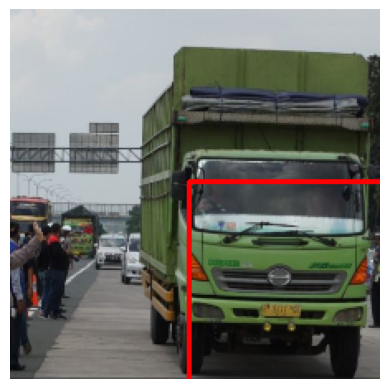

In [31]:
# Bounding box coordinates
bbox = bbox_prediction[0]  # Take the first prediction
x, y, w, h = bbox

# Reload original image for visualization
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))

# Draw a bounding box
start_point = (int(x), int(y))
end_point = (int(x + w), int(y + h))
color = (255, 0, 0)  # Warna kotak 
thickness = 2
img = cv2.rectangle(img, start_point, end_point, color, thickness)

# Plot image
plt.imshow(img)
plt.axis('off')
plt.show()

# Step 12: Save model to JSON format

In [32]:
# Save architecture to JSON format
model_json = model.to_json()
with open("/kaggle/working/model_architecture.json", "w") as json_file:
    json_file.write(model_json)

In [33]:
# Save model weight in .h5 format
model.save_weights("/kaggle/working/model.weights.h5")

In [34]:
# Load weight in .h5 format
model.load_weights("/kaggle/working/model.weights.h5")

# Save weight in .bin format
weights = model.get_weights()
with open("/kaggle/working/model_weights.bin", "wb") as f:
    for weight in weights:
        f.write(weight.tobytes())

# Step 13: Save model to saved_model format

In [35]:
# Path to save the model
saved_model_path = "/kaggle/working/saved_model"

# Save the model to .pb format
tf.saved_model.save(model, saved_model_path)

print(f"Model saved successfully in: {saved_model_path}")

Model saved successfully in: /kaggle/working/saved_model


In [36]:
# Create a zip file from the models folder
shutil.make_archive('/kaggle/working/saved_model', 'zip', '/kaggle/working/saved_model')

print("The model is compressed to saved_model.zip")

The model is compressed to saved_model.zip


# Step 14: Save model to Pickle format

In [37]:
import pickle
model_filename = '/kaggle/working/model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {model_filename}")

Model saved to /kaggle/working/model.pkl


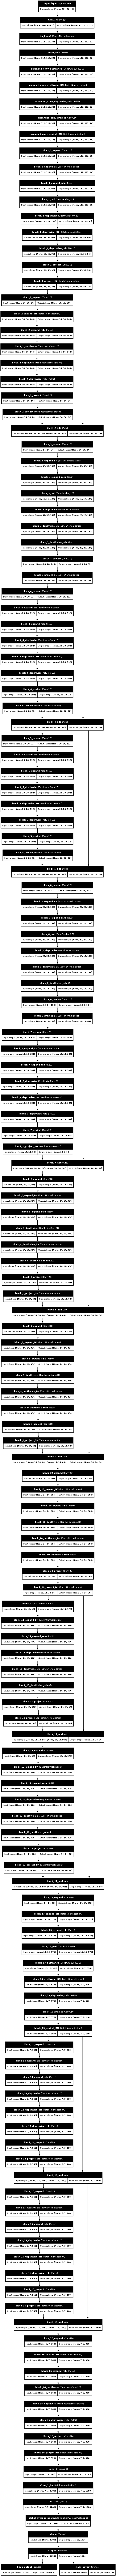

In [39]:
tf.keras.utils.plot_model(
    model,
    to_file='/kaggle/working/model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  
    expand_nested=False,
    dpi=50
)